# Capstone Project 1: Analysis on San Francisco Airbnb Data

## Data Story

#### Airbnb provides travellers with a new way to experience the place they are travelling to. By staying with local host, people may learn better about the history, the culture and the life in that place, and get deeper feelings from the trip. My analysis on the San Francisco Airbnb Data focuses on the price of listings, I'm going to explore the factors that related to the price and I hope it can be a guidance for people who are travelling to San Francisco.

##### 1. Read Data

In [34]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set_style('darkgrid')

In [32]:
# Read data
# calendar = pd.read_csv('calendar_clean.csv', parse_dates=['date'], index_col=0)
listings = pd.read_csv('listings_clean.csv', index_col=0)
listings.reset_index(inplace=True)
listings = listings[listings.price <= 1000]

##### 2. Visualizations

###### **Price**<br>

First let's check out the distribution of listing prices.<br>
    <br>
According to the histogram below, the distribution of price is right skewed with most listings priced under 200 dollars.

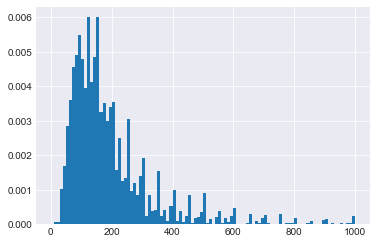

In [39]:
plt.hist(listings.price, bins=100, density=True)
plt.show()

###### **Host**<br>
Host is an important part of a listing. I'm going to explore how features of host are related to listing properties and price.<br>
<br>     
* **Host start year**<br>
<br>
    The line plot below shows the number of hosts joined per year. We can see that in 2008-2012 there was a fast increase in new hosts, and 2013 had the most newly-joined hosts. After 2013, number of new hosts dropped until 2018. The trend seems to match the home price trend, in 2008-2013 there was a continuous decline in home price after the market crash in 2008, and starting from 2013, the home market in San Francisco recovered with price increasing rapidly. This may indicate that the number of new hosts in Airbnb market is negatively related to the home price index, when home price is increasing, owners may tend to sell their extra properties instead of renting them out.    

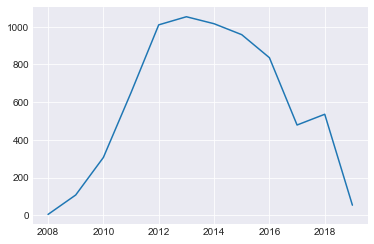

In [40]:
# Calculate the number of hosts start to host per year
listings.host_since = pd.to_datetime(listings.host_since, format='%Y-%m-%d')
hosts_by_year = listings.groupby(listings.host_since.dt.year).id.size()
hosts_by_year.columns = ['host_since', 'count']

# plot hosts_by_year
sns.set_style('darkgrid')
plt.plot(hosts_by_year)
plt.show()

   * **Superhost**<br>
   <br>
   Superhosts are hosts who meet certain criteria such as 4.8+ overall rating, 10+ stays during the past year etc.. Airbnb states that superhosts earn up to 22% more than other hosts. <br>
   <br>
   The boxplots below show that the distribution of price is quite similar regardless of superhost or not. However superhosts have a higher median number of reviews (which is related to number of bookings) than non-superhosts. Therefore superhost may not be related to higher price or lower price, but may be related to more reviews (more bookings).

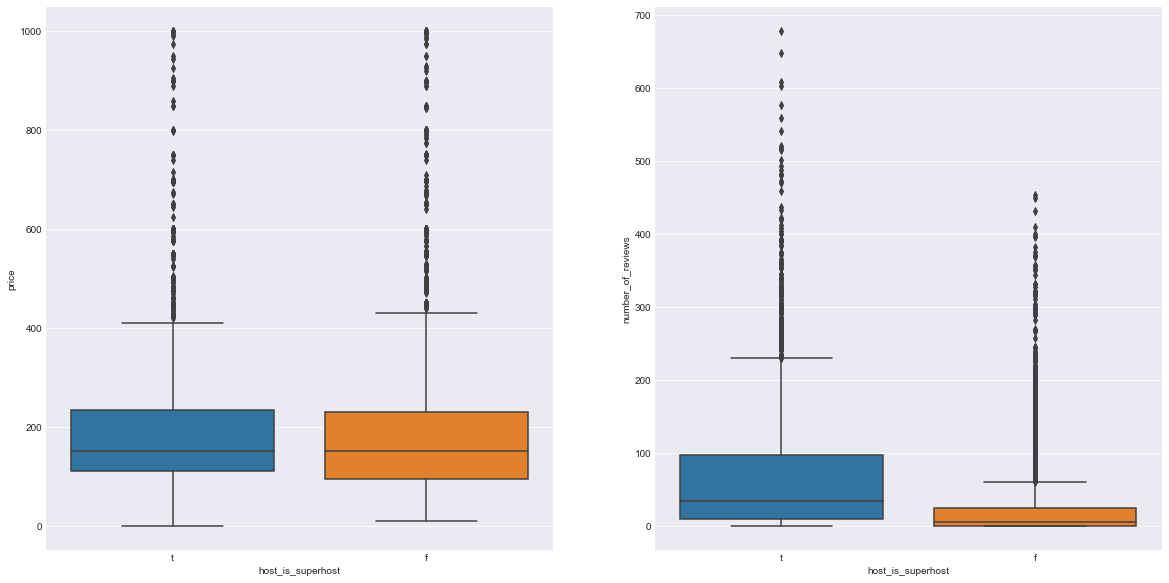

In [47]:
# superhost
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.boxplot(x='host_is_superhost', y='price', data=listings)

plt.subplot(1, 2, 2)
sns.boxplot(x='host_is_superhost', y='number_of_reviews', data=listings)
plt.show()

###### **Property**<br>
Property itself counts the most important part of the listing price. In this part I will check out couple of key features of a listing and see if there is any visible relationship between them and price.<br>
<br>
* **Neighborhood**<br>
    <br>
The map below shows the median listing price by neighborhoods in San Francisco. According to the map, listings in the northeastern part of SF have a relatively higher median price, and southern part has the lower median listing price.    

In [53]:
# Calculate the number of listings and the median of listing price by neighbourhood
listing_by_nbh = listings.groupby('neighbourhood_cleansed').agg(['size', 'median']).price
listing_by_nbh = listing_by_nbh.reset_index()
listing_by_nbh.columns = ['neighbourhood_SF', 'listing_counts', 'median_price']

In [95]:
# load GeoJson
with open('neighbourhoods.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

# Remove neighborhoods not in our dataset
geo_nbh = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['neighbourhood'] in list(listing_by_nbh['neighbourhood_SF'].unique()):
        geo_nbh.append(tmp['features'][i])

# Create new JSON object and save as updated file
new_json = dict.fromkeys(['type', 'features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geo_nbh

open('updated_neighbourhoods.json', 'w').write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

1934407

In [101]:
# Use folium module to show the median price of listings in each neighborhood on map
import folium

m = folium.Map(location = [37.7749, -122.4194], zoom_start = 12)

m.choropleth(
    geo_data=r'updated_neighbourhoods.json',
    name='choropleth',
    data=listing_by_nbh,
    threshold_scale=[85, 109, 134, 158, 182, 206],
    columns=['neighbourhood_SF', 'median_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Listing median price'
)

folium.LayerControl().add_to(m)

m

* **Number of people the listing can accommodate**<br>
    <br>
The number of people a listing can accommodate reflects the size of the listing. The histogram below shows the distribution of 'accommodates' column. Nearly half of the listings can accommodate only 2 people, and around 80% of the listings can accomodate 4 or less people. <br>
    <br>
The relationship between price and accommodates is intuitive: the more people can a listing accommodate, the higher the price tends to be. The scatter plot on the right indicates the relation with a linear regression line on it.

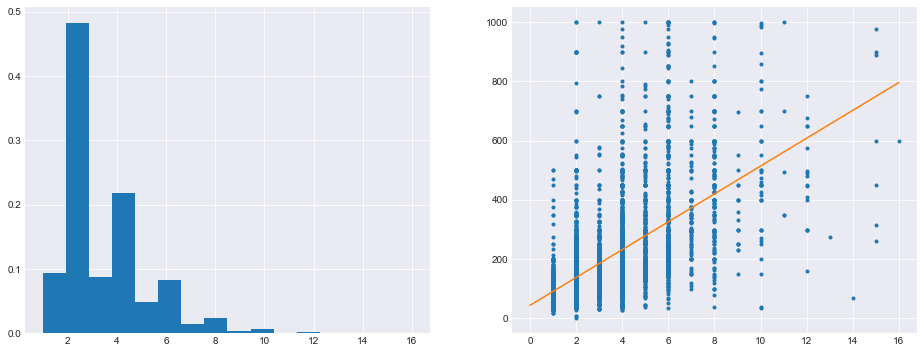

In [106]:
# Histogram of number of people the listing can accomodate
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.hist(listings.accommodates, bins=16, density=True)

# Accommodates vs price
a, b = np.polyfit(listings['accommodates'], listings['price'], 1)
x = np.array([0,16])
y = a*x + b
plt.subplot(1, 2, 2)
plt.plot(listings['accommodates'], listings['price'], marker='.', linestyle='none')
plt.plot(x, y)
plt.show()

* **Property type**<br>
   <br>
The bar plot below lists the top 10 property types across the city. Apartment and house are the 2 most common options. <br>
   <br> 
The boxplot shows the distribution of listing prices by property type. We can see that condominiums, boutique hotels, and loft have relatively higher median price, and hostels are usually lower priced. 

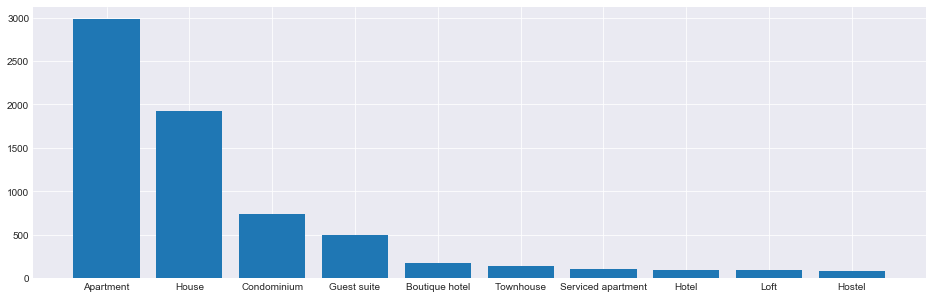

In [125]:
# Property types across the city 
property_type_SF = listings.groupby('property_type').id.size().sort_values(ascending=False).head(10)
plt.figure(figsize=(16,5))
plt.bar(property_type_SF.index, height=property_type_SF.values)
plt.show()

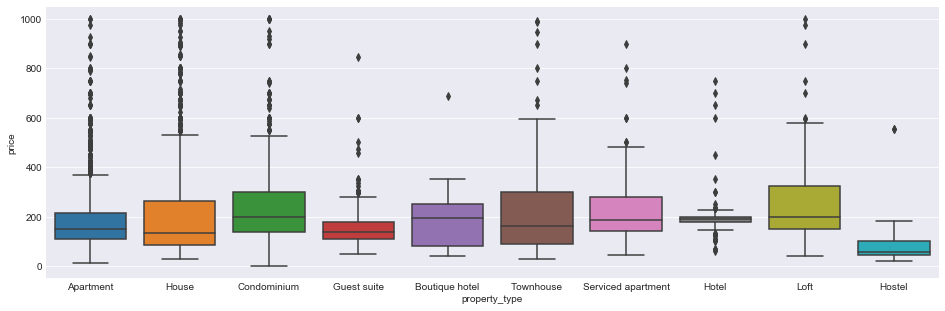

In [129]:
# boxplot of price by property type
plt.figure(figsize=(16,5))
sns.boxplot(x='property_type', y='price', 
            data=listings[[x in list(property_type_SF.index) for x in listings.property_type]],
            order=list(property_type_SF.index))
plt.show()

* **Room type**<br>
   <br>
The bar plot and boxplot show that most of the listings are entire home/apt with a highest median price among three room types. Shared rooms are not common comparing to entire home/apt and private room, but the price seems to be really nice - the median price of shared rooms is about 1/4 of that of entire home/apt!

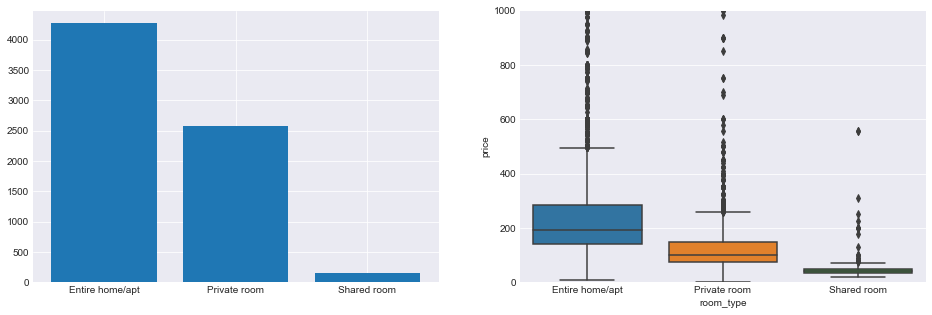

In [144]:
# Room type
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
room_type_SF = listings.groupby('room_type').id.size().sort_values(ascending=False)
plt.bar(room_type_SF.index, height=room_type_SF.values)

plt.subplot(1, 2, 2)
sns.boxplot(x='room_type', y='price', data=listings)
plt.ylim(0, 1000)
plt.show()

* **Cancellation policy**<br>
   <br>
Cancelling an Airbnb reservation is not hard in San Francisco. According to the bar plot below, over 40% of the listings have a strict cancellation policy with 14-day grace period, which means you can get a full refund if you cancel 14 days prior to your check-in date. In addition, about 35% of listings have a moderate cancellation and 20% have a flexible policy which allow users to get full refund when they cancel their reservation 5 days and 1 day prior to check in respectively.<br>
   <br>
However, the boxplot shows that the cancellation policy doesn't affect the price of a listing a lot. Each level of cancellation policy has a similar median price of listings.

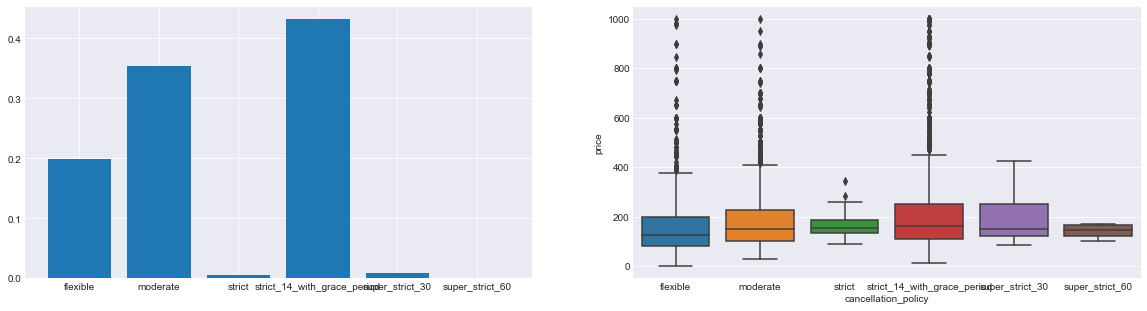

In [143]:
# cancellation policy
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
cancellation_policy_SF = (listings.groupby('cancellation_policy').id.size())/len(listings.id)
plt.bar(cancellation_policy_SF.index, height=cancellation_policy_SF.values)

plt.subplot(1, 2, 2)
sns.boxplot(x='cancellation_policy', y='price', data=listings, order=cancellation_policy_SF.index)
plt.show()

* **Cleaning fee**<br>
   <br>
Cleaning fee is an extra cost for Airbnb customers. Usually they need to pay a one-time cleaning fee when they make reservation, no matter how many nights they will stay. The following scatter plot shows that there is a postive correlation between cleaning fee and price. It is intuitive as the more cleaning fee it charges, the more labor it requires to clean the listing, and usually it indicates that the listing is either large or complicated.

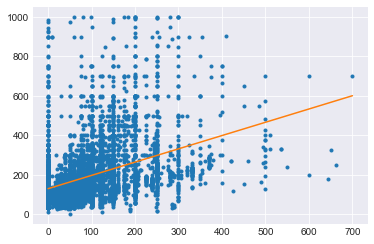

In [145]:
# cleaning fee
a2, b2 = np.polyfit(listings['cleaning_fee'], listings['price'], 1)
x2 = np.array([0,700])
y2 = a2*x2 + b2

plt.plot(listings['cleaning_fee'], listings['price'], marker='.', linestyle='none')
plt.plot(x2, y2)
plt.show()

###### **Reviews**<br>
Reviews measure how much customers like the listing. I'm going to check:<br>
1. review score, the rating of the listing<br>
2. number of reviews, an alternative of number of bookings<br>

* **Review score**<br>
<br>
Review score indicates how customers like the listing. The scatter plot below shows a positive correlation between them, that is, a higher rated listing is likely to have a higher price. 

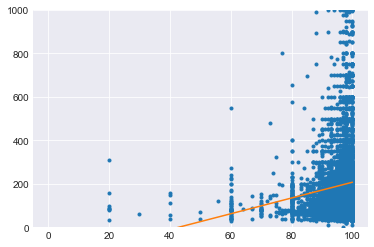

In [147]:
# review score
a3, b3 = np.polyfit(listings['review_scores_rating'], listings['price'], 1)
x3 = np.array([0,100])
y3 = a3*x3 + b3

plt.plot(listings['review_scores_rating'], listings['price'], marker='.', linestyle='none')
plt.plot(x3, y3)
plt.ylim(0,1000)
plt.show()

* **Number of reviews**<br>
<br>
Number of reviews can somewhat represent the popularity of the listing. The scatter plot below shows that price is negatively corrolated with number of reviews, which indicates that people prefer booking listings with lower price. 

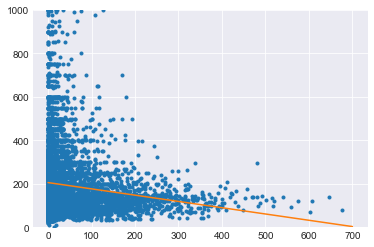

In [149]:
# number of reviews
a4, b4 = np.polyfit(listings['number_of_reviews'], listings['price'], 1)
x4 = np.array([0, 700])
y4 = a4*x4 + b4

plt.plot(listings['number_of_reviews'], listings['price'], marker='.', linestyle='none')
plt.plot(x4, y4)
plt.ylim(0, 1000)
plt.show()

##### 3. Conclusion<br>
The number of new Airbnb listings in the SF market depends on the home price in that area. A booming market of Airbnb may associated with a recession in home market.<br>
<br>
Superhosts earn more than regular hosts because they have more bookings instead of higher price!<br>
<br>
Listing features play an important role in deciding the price. The location/neighborhood, size, property type, and room type are all factors that have effects. Cleaning fee is excluded from nightly price, so be prepared to pay high cleaning fee for an expensive stay!<br>
<br>
Review score is positively correlated with price and number of reviews is negatively correlated with price. That means, people are more likely to book low price listings but they may have more fun with a higher priced listing!